In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   #osx

# Printing config:
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.expand_frame_repr', False) # for printing full objects

In [2]:
def colNameListByDType(df, numericCols=True):
    # # # # # # # # # #
    # Finds the names of numeric/non-numeric columns of a dataframe
    # Args:
    #       df - (pandas dataframe)
    #       numericCols - (bool), True - for numerical columns, False - for non-numerical columns
    # Return:
    #       col_name_list - (list of strings), the matched columns name
    # # # # # # # # # #
    from pandas.api.types import is_numeric_dtype

    col_name_list = list()
    for col in df.columns:
        if(numericCols): # if the numeric columns are required
            if(is_numeric_dtype(df[col]) == True):
                col_name_list += [col]
        else:   # the non-numeric columns are required
            if (is_numeric_dtype(df[col]) == False):
                col_name_list += [col]

    # apply doesn't work with is_numeric_dtype for some reason!
    #if(numericCols):
    #    col_name_list = df.columns[df.apply(lambda x: is_numeric_dtype(x))]
    #else:
    #    col_name_list = df.columns[~np.array(df.apply(is_numeric_dtype))]

    return col_name_list

In [3]:

def dataAnalysis(data_df, labelColName, plotSctrMat=False):
    # # # # # # # # # #
    # Analyse the dataset
    # Args:
    #       data_df - (pandas dataframe), the dataset
    #       labelColName - (string), the column name that represents the label (0/1)
    #       plotSctrMat - (bool), True for activating plot execution, False otherwise.
    # Return:
    #       Nothing)
    # # # # # # # # # #
    import random
    from pandas.plotting import scatter_matrix
    from scipy.stats import normaltest

    print("Data head :\n" + str(data_df.head()))
    print("Data shape : " + str(data_df.shape))  # (145818, 17)

    print(data_df.info())  # Checking cols data type and existence of missing values (by comparing the # of values in a col to the df # of rows).
    """ country = US :      47616
        non-missing county: 47616
        Meaning - there are no actual missing values under 'county' """

    # Basic statistics:
    print("% of target (label) = 1: " + str(100 * np.sum(data_df[labelColName]) / data_df.shape[0]))
    print(data_df.describe(include=[np.number]))  # Print summary of numeric features
    print(data_df.describe(include=['O']))  # Print summary of non-numeric features

    non_numeric_cols = colNameListByDType(data_df, numericCols=False)

    for col in non_numeric_cols:
        print('\nUnique value counts of column : ' + col)
        print(data_df[col].value_counts(normalize=True))

    # Check if the numeric columns in the dataset are coming from normal dist
    # (will help us decide how to scale the features later on):
    numeric_cols = colNameListByDType(data_df, numericCols=True)
    alpha = 1e-3
    for i in numeric_cols:
        k2, p = normaltest(data_df[i])  # null hypothesis: the feature comes from a normal distribution
        if (p < alpha):  # The null hypothesis can be rejected
            print("It is most likely that %s is not coming from a normal distribution, pval = %.4f" % (i, p))
        else:  # The null hypothesis cannot be rejected
            print("We cannot reject the hypothesis that %s is coming from a normal distribution, pval = %.4f" % (i, p))

    if(plotSctrMat):
        # Scatter plot of numeric features:
        numeric_cols = list(set(['port']).symmetric_difference(numeric_cols)) # 'port' has zero variance, ignore it in scatter plot
        sample_idx = random.sample(range(0, data_df.shape[0] - 1), 500)
        scatter_matrix(data_df.loc[sample_idx, numeric_cols])
        """ It seems like 'total_ime' has the greatest separation with respect to 'target'. """

    return

In [4]:

def colNamesToFilter(df, method, min_val):
    # # # # # # # # # #
    # Finds out which columns should be filtered (according to the specified method and min_val).
    # Args:
    #       df - (pandas dataframe), the dataset
    #       method - (string), possible values: 'freq' - frequency
    #                                           'std' - standard deviation
    #       min_val - (float), columns with method value lower or equal to this argument will be filtered
    # Return:
    #       f_cols - (list of strings), list of column names to filter
    # # # # # # # # # #
    f_cols = []
    if(method == 'freq'):
        cols_method = df.astype(bool).sum(axis=0)
    elif(method == 'std'):
        cols_method = df.std(axis=0)
    else:
        print("colNamesToFilter warning: method is empty, no filter will be applied.")
    f_cols += list(cols_method[cols_method <= min_val].index)
    return f_cols


In [5]:

def extractFeaturesFromPath(path_sr):
    # # # # # # # # # #
    # Extract new features from the elements constructing a 'path' (column)
    # Args:
    #       path_sr - (pandas series), the 'path' column (a column of strings with '/' delimiter)
    # Return:
    #       w_freq_df - (pandas dataframe), the new extracted features - word frequencies (original indices for future merge)
    # # # # # # # # # #
    from sklearn.feature_extraction.text import CountVectorizer

    delimiter = "/"
    # Add 'empty_end' string to paths that end with "/", most likely represent a directory:
    end_dlt_idx = path_sr.str.endswith(delimiter)
    path_sr.loc[end_dlt_idx] = path_sr.loc[end_dlt_idx].apply(lambda x: x + "empty_end")
    path_sr = path_sr.apply(lambda x: x.replace(delimiter, " "))
    cv = CountVectorizer()
    cv.fit(path_sr)
    print("DEBUG: number of words: %d" % len(cv.vocabulary_))
    w_freq_csr = cv.transform(path_sr)
    cols_name = ["path_" + i for i in cv.get_feature_names()]
    w_freq_df = pd.DataFrame(w_freq_csr.todense(), columns=cols_name)
    remove_cols = colNamesToFilter(w_freq_df, method='freq', min_val=10)
    w_freq_df.drop(columns=remove_cols, inplace=True)  # dropping rare features (less than 10 occurrences)
    print("Adding %d features extracted from 'path'." % w_freq_df.shape[1])
    return w_freq_df


In [6]:

def featureDistPlot(df):
    # # # # # # # # # #
    # Plot the pdf of the features in a dataset
    # Args:
    #       df - (pandas dataframe), the dataset, where the columns represent the features
    # Return:
    #       Nothing
    # # # # # # # # # #
    import seaborn as sns

    f, axes = plt.subplots(1, df.shape[1], figsize=(20, 3))#, sharex=True)
    for i in range(0, df.shape[1]):
        df[df.columns[i]].plot.kde(ax=axes[i])
        #sns.distplot(df[df.columns[i]], ax=axes[i]) #hist=True, norm_hist=True
    plt.show(block=False)

    return


In [7]:

def featureScaling(data_df, fe_to_scale_list, plotDist=False):
    # # # # # # # # # #
    # Scale (MinMax) the specified columns of a dataset [0,1]
    # Note: we don't perform standardization because the continues features are not normally distributed.
    # Args:
    #       data_df - (pandas dataframe), the dataset, where the columns represent the features
    #       fe_to_scale_list - (list of strings), feature names to scale.
    #       plotDist - (bool), True for activating plot execution, False otherwise.
    # Return:
    #       s_data_df - (pandas dataframe), the scaled dataset
    # # # # # # # # # #
    from sklearn.preprocessing import MinMaxScaler

    s_data_df = data_df.copy(deep=True)

    # Plot the feature distribution to analyse if log-transform is required:
    min_max_scaler = MinMaxScaler()
    s_data_df[fe_to_scale_list] = min_max_scaler.fit_transform(s_data_df[fe_to_scale_list])
    if(plotDist):
        # Plot the features (fe_to_scale_list) dist:
        featureDistPlot(s_data_df[fe_to_scale_list])
        """Log-transform won't help us in this case to approximate to normal distribution."""

    return s_data_df


In [8]:

def preprocData(data_df, labelColName, plotFeDist=False):
    # # # # # # # # # #
    # Preprocess dataset - feature extraction, feature reduction and feature scaling
    # Note: we didn't clean outliers because the numerical features were not normally distributed, even after log transformation.
    #       Also, no missing data handling is done, because there are no such cases in our dataset.
    # Args:
    #       data_df - (pandas dataframe), the 'path' column (a column of strings with '/' delimiter)
    #       labelColName - (string), the column name that represents the label (0/1)
    #       plotFeDist - (bool), True for activating plot execution, False otherwise.
    # Return:
    #       pp_data_df - (pandas dataframe), the preprocessed dataset
    # # # # # # # # # #
    import re

    # FEATURE EXTRACTION:
    # Convert categorical features to dummy features:
    categorical_cols = list(set(['path']).symmetric_difference(colNameListByDType(data_df, numericCols=False)))
    pp_data_df = pd.get_dummies(data=data_df, columns=categorical_cols, drop_first=True)

    # Extract features (keywords) from 'path':
    path_fe_df = extractFeaturesFromPath(pp_data_df['path'])
    pp_data_df = pd.merge(pp_data_df, path_fe_df, left_index=True, right_index=True)


    # FEATURE REDUCTION:
    remove_cols = []
    # Correlation analysis:
    abs_corr_df = pp_data_df.corr().abs() # (absolute value) correlation matrix
    # the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1):
    ordered_abs_corr = (abs_corr_df.where(np.triu(np.ones(abs_corr_df.shape), k = 1).astype(np.bool)).stack().sort_values(ascending=False))

    # Find redundant features:
    corr_threshold = 0.9
    corr_fe = ordered_abs_corr[ordered_abs_corr >= corr_threshold] # series object with 2 indices (2 features)
    # print("DEBUG: abs(correlation) == 1 :\n%s" % corr_fe)
    corr_fe_index_1 = corr_fe.index.get_level_values(0)
    corr_fe_index_2 = corr_fe.index.get_level_values(1)
    # Define the redundant features list:
    if(any(re.search(labelColName, i) != None for i in corr_fe_index_1) == False): # If 'target' is not in corr_fe first index
        remove_cols += list(corr_fe_index_1)
    elif(any(re.search(labelColName, i) != None for i in corr_fe_index_2) == False):  # If 'target' is not in corr_fe second index
        remove_cols += list(corr_fe_index_2)
    else: # 'target' is in both indices - not supported for now.
        print("%s is in both corr_fe indices. This scenario is not yet supported - no high-correlation filter will be applied.")

    # Zero std filter:
    remove_cols += colNamesToFilter(pp_data_df, method='std', min_val=0.)
    # Frequency filter:
    remove_cols += colNamesToFilter(pp_data_df, method='freq', min_val=10.)
    remove_cols += ['path']
    remove_cols = set(remove_cols) # Remove duplicates

    print(("High correlation + std + freq filters: delete %d out of %d columns.") % (len(remove_cols), pp_data_df.shape[1]))
    pp_data_df.drop(columns=remove_cols, inplace=True)

    # Multicollinearity filter (detected by existence of tiny eigenvalues of the correlation matrix)
    """ 
        Existence of tiny eigenvalues (very close to zero) and high sqrt(max_eigval/min_eigval) of the correlation matrix 
        implies multicollinearity existence. The corresponding eigenvectors can detail the dependency of the features.
        """
    corr_df = pp_data_df.drop(columns=[labelColName]).corr()
    remove_cols = []
    eigval, eigvec = np.linalg.eig(corr_df)
    min_eigval = 0.001
    small_eigval_idx = np.where(eigval <= min_eigval)[0]
    for i in small_eigval_idx:
        #print("DEBUG: Eigenvector of eigenvalue %.15f :\n%s\n" % (eigval[i], eigvec[:, i]))
        # Keep only one of the major features and remove the rest
        remove_cols += list(corr_df.columns[np.where(np.abs(eigvec[:, i]) >= 0.01)[0]][:-1])
        #print("DEBUG: multicollinearity (major) relation: %s" % list(corr_df.columns[np.where(np.abs(eigvec[:, i]) >= 0.1)[0]]))

    remove_cols = set(remove_cols) # Remove duplicates
    print(("Multicollinearity filter: delete %d out of %d columns.") % (len(remove_cols), pp_data_df.shape[1]))
    #print("DEBUG: remove_cols = %s" % remove_cols)
    pp_data_df.drop(columns=remove_cols, inplace=True)
    print("Preprocessed data shape after feature reduction - " + str(pp_data_df.shape))


    # FEATURE SCALING:
    fe_to_scale_list = pp_data_df.columns[np.array(pp_data_df.apply(lambda x: x.min() < 0)) | np.array(pp_data_df.apply(lambda x: x.max() > 1))]
    pp_data_df = featureScaling(pp_data_df, fe_to_scale_list, plotDist=plotFeDist)

    return pp_data_df


In [9]:

def defineClassifiers():
    # # # # # # # # # #
    # Define classifiers - Decision Tree, Random Forest, SVM
    # Args:
    #       Nothing
    # Return:
    #       clf_list - (list of sklearn classifier objects BEFORE FITTING)
    # # # # # # # # # #
    from sklearn import tree
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC

    dt = tree.DecisionTreeClassifier(max_depth=1)  # , min_samples_leaf=100)
    rf = RandomForestClassifier(max_depth=3, random_state=0)  # , min_samples_leaf=100))
    svm = SVC(kernel='linear')

    clf_list = [dt, rf, svm]

    return clf_list


In [10]:

def evaluateClassifiers(X, y, clf_list):
    # # # # # # # # # #
    # Evaluate classifiers that were NOT FITTED - precision, recall, f1
    # Args:
    #       X - (pandas dataframe), the design matrix (without train/test split)
    #       y - (pandas series), the labels (without train/test split)
    #       clf_list - (list of sklearn classifier objects BEFORE FITTING)
    # Return:
    #       best_clf - (sklearn classifier object) best classifier - the one with max(E[F1_scores])
    # # # # # # # # # #
    from sklearn.model_selection import cross_validate, ShuffleSplit

    cv = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
    scoring = ('precision', 'recall', 'f1')
    f1_scores = []
    for clf in clf_list:
        print("\nEvaluate classifier: %s" % type(clf))
        # for regular K-fold use c=k:
        scores = cross_validate(clf, X, y, cv=cv, scoring=scoring)
        f1_scores.append(scores["test_f1"].mean())
        for s in scoring:
            print("(class 1) %s: %f" % (s, scores["test_" + s].mean()))
    f1_scores = np.array(f1_scores)
    best_clf = clf_list[np.where(f1_scores == max(f1_scores))[0][0]]
    return best_clf


In [11]:

def plotTopFeatures(coef_nparr, fe_name_list, top_features=20):
    # # # # # # # # # #
    # Plots the k min and max coefficients
    # Args:
    #       coef_nparr - (numpy ndarray), the model's coefficients
    #       fe_name_list - (list of strings), the features names
    #       top_features - (int), k
    # Return:
    #       Nothing
    # # # # # # # # # #

    top_positive_coefficients = np.argsort(coef_nparr)[-top_features:]
    top_negative_coefficients = np.argsort(coef_nparr)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # Create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef_nparr[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef_nparr[top_coefficients], color=colors)
    feature_names = np.array(fe_name_list)
    plt.xticks(np.arange(0,  2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show(block=False)

    return


In [12]:

def main(data_f_path, label_col_name, act_plots=False):
    # # # # # # # # # #
    # Main function
    # Args:
    #       data_f_path - (string), the path for the data file
    #       label_col_name - (string), the label column name
    #       act_plots - (bool), True for activating plots during the run, False otherwise.
    # Return:
    #       Nothing
    # # # # # # # # # #

    # Load the data
    data = pd.read_csv(data_f_path)

    dataAnalysis(data, label_col_name, plotSctrMat=act_plots)
    ppData = preprocData(data, label_col_name, plotFeDist=act_plots)
    clf_list = defineClassifiers()

    X = ppData.drop(columns=label_col_name)
    y = ppData[label_col_name]
    clf = evaluateClassifiers(X, y, clf_list)
    print("We recommend using the following classifier for predicting %s:\n%s" % (label_col_name, clf))

    # Plot the most important features:
    clf.fit(X, y)  # train the classifier on the entire dataset
    if (str(type(clf)) == "<class 'sklearn.svm.classes.SVC'>"):  # SVM
        coefs = clf.coef_.ravel()
    elif (str(type(clf)) in ["<class 'sklearn.ensemble.forest.RandomForestClassifier'>",
                             # Decision Tree / Random Forest
                             "<class 'sklearn.tree.tree.DecisionTreeClassifier'>"]):
        coefs = clf.feature_importances_.ravel()
    else:
        coefs = []
        print("Unrecognized model, we cannot plot the model's most important features.")
    plotTopFeatures(coefs, X.columns, top_features=6)
    print("End of main()")

    return


Data head :
   target       path                                      user_agent country   fuel  source_port    city county  contacts_n  latitude  longitude  bandwidth  respose timezone  download_time  port  time_total
0       1  /rss/news  FeedNotifier/2.6 +http://www.feednotifier.com/      GB 5.8229        52260  LONDON    NaN           7   51.5000    -0.1200       5000       35      GMT             73    -1     57.6208
1       1  /rss/news  FeedNotifier/2.6 +http://www.feednotifier.com/      GB 4.6307        51355  LONDON    NaN           3   51.5000    -0.1200       5000       31      GMT             87    -1     53.9166
2       1  /rss/news  FeedNotifier/2.6 +http://www.feednotifier.com/      GB 4.4599        58974  LONDON    NaN           6   51.5000    -0.1200       5000       43      GMT             82    -1     56.4803
3       1  /rss/news  FeedNotifier/2.6 +http://www.feednotifier.com/      GB 3.5263        58309  LONDON    NaN           5   51.5000    -0.1200       5000     

LOUDOUN         0.6994
ORANGE          0.2102
NEWYORK         0.0748
BOULDER+WELD    0.0107
ELPASO          0.0041
DUPAGE          0.0005
FULTON+DEKALB   0.0002
GWINNETT        0.0001
FRANKLIN        0.0000
Name: county, dtype: float64

Unique value counts of column : timezone
GMT      0.6643
EST      0.2530
PST      0.0686
GMT+1    0.0090
MST      0.0048
CST      0.0002
GMT+10   0.0000
EST+1    0.0000
Name: timezone, dtype: float64
It is most likely that target is not coming from a normal distribution, pval = 0.0000
It is most likely that fuel is not coming from a normal distribution, pval = 0.0000
It is most likely that source_port is not coming from a normal distribution, pval = 0.0000
It is most likely that contacts_n is not coming from a normal distribution, pval = 0.0000
It is most likely that latitude is not coming from a normal distribution, pval = 0.0000
It is most likely that longitude is not coming from a normal distribution, pval = 0.0000
It is most likely that bandwidth is

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


DEBUG: number of words: 2054
Adding 424 features extracted from 'path'.


KeyboardInterrupt: 

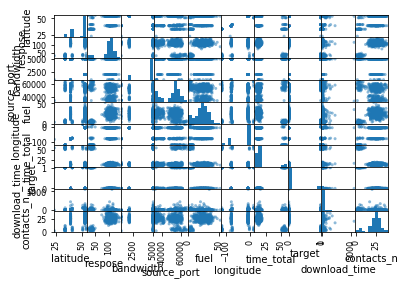

In [13]:

dataFilePath = "./data.csv"
labelColName = 'target'
actPlotsFlag = True

main(dataFilePath, labelColName, actPlotsFlag)